In [1]:
# ! pip uninstall /Path/to/the/whl/file/torchlogic-0.0.1-py3-none-any.whl -y

In [2]:
# ! pip install /Path/to/the/whl/file/torchlogic-0.0.1-py3-none-any.whl

In [3]:
# ! pip install optuna

In [4]:
# ! homebrew install cmake
# ! pip install cvxpy-base
# ! pip install aix360

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Choices for a categorical distribution should be a tuple")
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended")
warnings.filterwarnings("ignore", message="IProgress not found")

import copy

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler

import optuna
import numpy as np
import pandas as pd
from scipy.special import softmax

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from aix360.algorithms.rbm import FeatureBinarizerFromTrees

from torchlogic.models import BanditNRNRegressor
from torchlogic.utils.trainers import BanditNRNTrainer

In [6]:
# If we want the logs from Bandit-RRN training

# from carrot.logger import Logger

# log_config = 'configs/logging.yaml'
# log_dir = 'logs'
# logger = Logger.get(log_config, log_dir)

# Load Data

In [7]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
n_samples, n_features = X.shape

In [8]:
X, y = X.head(1000), y.head(1000)  # sample the data just for demonstration purposes

# Prepare Bandit-RRN Data

A dataset for the Bandit-RRN algorithm in torchlogic must return a dictionary of the following form:

```python
{
    'features': [N_FEATURES], 'target': [N_TARGETS], 'sample_idx': [1]
}
```

- The `features` key contains a tensor of the features used for prediction.  Feature must be numeric and scaled between 0 and 1.

- The `target` key must contain a tensor of the targets, with the values of 0 or 1 for each target.

- The `sample_idx` key must contain a tensor of the row number in the data corresponding to that sample.

## Preprocess Data

For Reasoning Networks (RNs) all values must be scaled between 0 and 1.  For a regression problem, this includes the targets.  We can use a MinMaxScaler
for both our features and targets, separately.  Note that the RN will not make predictions below 0, or above 1.  This means, we won't make predictions below the
minimum of our training data, or above the maximum of our training data.  If we would like to enable predictions outside the range of our training data, we could scale our values to some Min greater than 0 and Max less than 1.

However, in this tutorial, we will take a different approach to transforming our input data, using FeatureBinarizationFromTrees rather than MinMaxScaler.  We detail the approach in the next section.

### Prepare the Feature Names

To aid in the explantions of our model, we can set our feature names to natural language that represents the values of the feature.
In the current data, each feature represents a measurement in centimeters and is scaled between 0 to 1, so represents a percentile.
We rename each feature to describe this represenation of our data, which is then used when extracting explanations from the model.

In [9]:
X.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [10]:
X.columns = ['the median income is', 'the age of the house is', 'the average number of rooms is', 
             'the average number of bedrooms is', 'the city population is',
             'the average occupancy is', 'the latitude of the house is', 
             'the longitude of the house is']

In [11]:
mmsy = MinMaxScaler()
y_scaled = mmsy.fit_transform(y.values.reshape(-1, 1))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=42)

# convert to dataframes for BanditRRNDataset
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## Define PyTorch Dataset

### Format binarized feature names

Our FeatureBinarizationFromTrees transformation will result in non-natural language feature names.  We'll re-format the resulting feature names in order to maintain the natural language outputs we started constructing in the previous section by renaming our features.  The following function performs a formatting tranformation to the columns generated by the FeatureBinarizationFromTrees process.

In [13]:
def format_binarized_feature_names(binarized_column_names):
    return list(
        map(
            lambda x: str(x).replace("(", "").replace(")", "")
            .replace("/", " ").replace(",", "").replace("'", "")
            .replace(" >= ", " greater than or equal to ").replace(" < ", " less than ")
            .replace(" <= ", " less than or equal to ").replace(" > ", " greater than "), 
            binarized_column_names
        )
    )

In [14]:
class BanditNRNDataset(Dataset):
    def __init__(
            self,
            X: np.array,
            y: np.array,
            tree_num: int = None,
            tree_depth: int = None,
            tree_feature_selection: float = None,
            thresh_round: int = None,
            fbt: FeatureBinarizerFromTrees = None
    ):
        """
        Dataset suitable for BanditRRN model from torchlogic

        Args:
            X (np.array): features data scaled to [0, 1]
            y (np.array): target data of classes 0, 1
        """
        super(BanditNRNDataset, self).__init__()
        self.X = X
        self.y = y
        self.sample_idx = np.arange(X.shape[0])  # index of samples
        self.fbt = fbt
        self.feature_names = None
        
        assert isinstance(X, pd.DataFrame), "X must be a dataframe with correct column names"
        
        if self.fbt is None:
            fit_fbt = True
        else:
            fit_fbt = False
        
        if (self.fbt is None
            and (tree_num is not None
                 or tree_depth is not None
                 or tree_feature_selection is not None
                 or thresh_round is not None)):
            assert tree_num is not None and tree_depth is not None \
                and tree_feature_selection is not None and thresh_round is not None, \
                ("all of 'tree_num', 'tree_depth', 'tree_feature_selection' and 'thresh_round' must be provided "
                 "when using FeatureBinarizationFromTrees.")
            self.tree_num = tree_num
            self.tree_depth = tree_depth
            self.tree_feature_selection = tree_feature_selection
            self.thresh_round = thresh_round
            self.fbt = FeatureBinarizerFromTrees(
                treeNum=tree_num,
                treeDepth=tree_depth,
                treeFeatureSelection=tree_feature_selection,
                threshRound=thresh_round,
                randomState=0
            )

        if self.fbt is not None:
            numeric_columns = self.X.columns[self.X.nunique() > 2]
            categorical_columns = self.X.columns[self.X.nunique() <= 2]
            x_numeric = self.X[numeric_columns]
            x_categorical = self.X[categorical_columns]
            if fit_fbt:
                # NOTE: to fit the tree based binarizer we need a categorical target
                x_numeric = self.fbt.fit_transform(x_numeric, self.y > self.y.mean())
            else:
                x_numeric = self.fbt.transform(x_numeric)

            # new feature names
            x_numeric.columns = format_binarized_feature_names(x_numeric.columns.to_flat_index())

            self.feature_names = list(x_numeric.columns) + list(categorical_columns)
            self.X = np.hstack([x_numeric.values, x_categorical.values])
        else:
            self.feature_names = list(self.X.columns)
            self.X = self.X.to_numpy()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        features = torch.from_numpy(self.X[idx, :]).float()
        target = torch.from_numpy(self.y[idx, :]).float()
        return {'features': features, 'target': target, 'sample_idx': idx}

## Define helper functions for Datasets and Data Loaders

In [15]:
def create_holdout_samplers(train_dataset, pct=0.2):
    train_size = len(train_dataset)
    indices = list(range(train_size))
    np.random.seed(0)
    np.random.shuffle(indices)
    
    train_holdout_split_index = int(np.floor(pct * train_size))
    train_idx, train_holdout_idx = indices[train_holdout_split_index:], indices[:train_holdout_split_index]
    
    train_sampler = SubsetRandomSampler(train_idx)
    train_holdout_sampler = SubsetRandomSampler(train_holdout_idx)
    
    return train_sampler, train_holdout_sampler

# Train Bandit-RRN Model

## Tune Hyper-parameters

In [16]:
torch.random.manual_seed(0)
np.random.seed(0)
g = torch.Generator()
g.manual_seed(0)

class TuneParameters:
    
    def __init__(self, n_trials=10):
        self.best_model = None
        self.best_rn_val_performance = 1e12
        self.n_trials = n_trials
        self.study = None

    def _objective(self, trial):

        ############################################################################################################################
        # NOTE: These hyper-parameter settings are specific to the california housing dataset.  For information on generally useful
        # ranges of hyper-parameters and their descriptions see our documentation: 
        ############################################################################################################################

        # Set Parameters
        
        ## Reinforced Reasoning Network Parameters
        layer_sizes = trial.suggest_categorical('layer_sizes', [(2, ), (3, ), (5, ), (10, ), (20, ),
                                                                (2, 2), (3, 3), (5, 5), (10, 10), (20, 20)])
        n_selected_features_internal = trial.suggest_int('n_selected_features_internal', low=2, high=min(5, min(layer_sizes)))
        n_selected_features_output = trial.suggest_int('n_selected_features_output', low=2, high=min(3, layer_sizes[-1]))
        perform_prune_plateau_count = trial.suggest_int('perform_prune_plateau_count', low=1, high=8)
        perform_prune_quantile = trial.suggest_float('perform_prune_quantile', low=0.1, high=0.9)
        increase_prune_plateau_count = trial.suggest_int('increase_prune_plateau_count', low=0, high=20)
        increase_prune_plateau_count_plateau_count = trial.suggest_int('increase_prune_plateau_count_plateau_count', low=10, high=30)
        ucb_scale = trial.suggest_float('ucb_scale', low=1.5, high=2.0)
        normal_form = trial.suggest_categorical('normal_form', ['dnf', 'cnf'])
        prune_strategy = trial.suggest_categorical('prune_strategy', ['class', 'logic', 'logic_class'])
        delta = trial.suggest_float('delta', low=2.0, high=2.0)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        swa = trial.suggest_categorical('swa', [True, False])
        add_negations = trial.suggest_categorical('add_negations', [False])
        weight_init = trial.suggest_float('weight_init', low=0.01, high=1.0)

        ## Optimizer Parameters

        ### Learning Rate
        learning_rate = trial.suggest_float('learning_rate', low=0.01, high=0.5)

        ### Weight Decay Regularization
        use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
        if use_weight_decay:
            weight_decay = trial.suggest_float('weight_decay', low=0.00001, high=0.1)
        else:
            weight_decay = 0

        ### Lookahead Optimization
        use_lookahead = trial.suggest_categorical('use_lookahead', [True, False])
        if use_lookahead:
            lookahead_steps = trial.suggest_int('lookahead_steps', low=5, high=10, step=1)
            lookahead_steps_size = trial.suggest_float('lookahead_steps_size', low=0.5, high=0.8)
        else:
            lookahead_steps = 0
            lookahead_steps_size = 0

        ### Data Augmentation
        ### Only AT data augmentation is applicable for regression tasks and it does not work in Jupyter Notebooks
        augment = None
        augment_alpha = 0
        # # augment = trial.suggest_categorical('augment', ['CM', 'MU', 'AT', None])
        # if augment is not None:
        #     augment_alpha = trial.suggest_float('augment_alpha', low=0.0, high=1.0)
        # else:
        #     augment_alpha = 0

        ### Early Stopping
        early_stopping_plateau_count = trial.suggest_int('early_stopping_plateau_count', low=20, high=50, step=1)
        
        ## Scheulder parameters
        t_0 = trial.suggest_int('T_0', low=2, high=10, step=1)
        t_mult = trial.suggest_int('T_mult', low=1, high=3, step=1)

        ### Tree Binarization
        if add_negations:
            use_fbt = False
        else:
            use_fbt = trial.suggest_categorical('use_fbt', [True])
        if use_fbt:
            tree_num = trial.suggest_int("fbt_tree_num", low=2, high=20)
            tree_depth = trial.suggest_int("fbt_tree_depth", low=2, high=10)
            tree_feature_selection = trial.suggest_float("fbt_tree_feature_selection", low=0.3, high=1.0)
            thresh_round = trial.suggest_int("fbt_thresh_round", low=0, high=3)
            train_dataset = BanditNRNDataset(
                X=X_train, 
                y=y_train,
                tree_num=tree_num,
                tree_depth=tree_depth,
                tree_feature_selection=tree_feature_selection,
                thresh_round=thresh_round
            )
            val_dataset = BanditNRNDataset(X=X_val, y=y_val, fbt=train_dataset.fbt)
        else:
            train_dataset = BanditNRNDataset(X=X_train, y=y_train)
            val_dataset = BanditNRNDataset(X=X_val, y=y_val)

        # NOTE: Tree Binarizataion changes the number of features so input feature selection must be performed after that process
        n_selected_features_input = trial.suggest_int('n_selected_features_input', low=2, high=min(15, len(train_dataset.feature_names)))

        train_sampler, train_holdout_sampler = create_holdout_samplers(train_dataset)

        train_dl = DataLoader(
            train_dataset, batch_size=32, generator=g, sampler=train_sampler,
            pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
        )
        train_holdout_dl = DataLoader(
            train_dataset, batch_size=32, generator=g, sampler=train_holdout_sampler,
            pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
        )
        val_dl = DataLoader(
            val_dataset, batch_size=32, generator=g, 
            pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
        )
            
        # init model
        model = BanditNRNRegressor(
            target_names='price_label',
            feature_names=train_dataset.feature_names,
            input_size=len(train_dataset.feature_names),
            layer_sizes=layer_sizes,
            n_selected_features_input=n_selected_features_input,
            n_selected_features_internal=n_selected_features_internal,
            n_selected_features_output=n_selected_features_output,
            perform_prune_quantile=perform_prune_quantile,
            ucb_scale=ucb_scale,
            normal_form=normal_form,
            delta=delta,
            prune_strategy=prune_strategy,
            bootstrap=bootstrap,
            swa=swa,
            add_negations=add_negations
        )

        epochs = 200
        accumulation_steps = 1
        optimizer = optim.Adam(model.rn.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=t_0, T_mult=t_mult)
        trainer = BanditNRNTrainer(
            model=model,
            loss_func=nn.MSELoss(),
            optimizer=optimizer,
            scheduler=scheduler,
            epochs=epochs,
            accumulation_steps=accumulation_steps,
            early_stopping_plateau_count=early_stopping_plateau_count,
            perform_prune_plateau_count=perform_prune_plateau_count,
            increase_prune_plateau_count=increase_prune_plateau_count,
            increase_prune_plateau_count_plateau_count=increase_prune_plateau_count_plateau_count,
            lookahead_steps=lookahead_steps,
            lookahead_steps_size=lookahead_steps_size,
            augment=augment,
            augment_alpha=augment_alpha,
            objective='minimize'  # Must pass minimize objective since we are using mean_squared_error as our performance metric
        )

        # train model
        # The trainer defaults to optimizing the validation roc_auc_score.  To optimize against a different metric pass the sklearn metric to the 'evaluation_metric' parameter
        trainer.train(train_dl, train_holdout_dl, evaluation_metric=mean_squared_error, multi_class=True)
        trainer.set_best_state()

        # evaluate model
        predictions, targets = trainer.model.predict(val_dl)
        rn_val_performance = trainer.model.evaluate(
            predictions=predictions,
            labels=targets,
            output_metric=mean_squared_error
        )

        if rn_val_performance < self.best_rn_val_performance:
            self.best_rn_val_performance = rn_val_performance
            self.best_model = copy.copy(trainer.model)
            self.best_model.rn = copy.deepcopy(trainer.model.rn)

        return rn_val_performance
    
    def tune(self):
        # 3. Create a study object and optimize the objective function.
        sampler = optuna.samplers.TPESampler(multivariate=True, group=True, seed=42)
        self.study = optuna.create_study(direction='minimize', sampler=sampler)
        self.study.optimize(self._objective, n_trials=self.n_trials)
        return self.best_model



In [ ]:
tuner = TuneParameters(2)
best_model = tuner.tune()

In [18]:
### Tree Binarization
if 'use_fbt' in tuner.study.best_params and tuner.study.best_params['use_fbt']:
    train_dataset = BanditNRNDataset(
        X=X_train, 
        y=y_train,
        tree_num=tuner.study.best_params['fbt_tree_num'],
        tree_depth=tuner.study.best_params['fbt_tree_depth'],
        tree_feature_selection=tuner.study.best_params['fbt_tree_feature_selection'],
        thresh_round=tuner.study.best_params['fbt_thresh_round']
    )
    val_dataset = BanditNRNDataset(X=X_val, y=y_val, fbt=train_dataset.fbt)
    test_dataset = BanditNRNDataset(X=X_test, y=y_test, fbt=train_dataset.fbt)
else:
    train_dataset = BanditNRNDataset(X=X_train, y=y_train)
    val_dataset = BanditNRNDataset(X=X_val, y=y_val)
    test_dataset = BanditNRNDataset(X=X_test, y=y_test)

train_dl = DataLoader(
    train_dataset, batch_size=32, generator=g, shuffle=False,
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)
val_dl = DataLoader(
    val_dataset, batch_size=32, generator=g, shuffle=False,
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)
test_dl = DataLoader(
    test_dataset, batch_size=32, generator=g, shuffle=False,
    pin_memory=False, persistent_workers=False, num_workers=0  # very important to optimize these settings in production
)

In [19]:
predictions, targets = best_model.predict(val_dl)
# Evaluate defaults to compute AUC
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    multi_class=True,
    output_metric=mean_squared_error
)
print("Validation MSE:\n\n", rn_val_performance)

# Evaluate with a different metric
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=r2_score,
    multi_class=True
)
print("\n\nValidation R^2:\n\n", rn_val_performance)

Validation MSE:

 0.02023284323513508


Validation R^2:

 0.37921359875430616


In [20]:
predictions, targets = best_model.predict(test_dl)
# Evaluate defaults to compute AUC
rn_test_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    multi_class=True,
    output_metric=mean_squared_error
)
print("Test MSE:\n\n", rn_test_performance)

# Evaluate with a different metric
rn_val_performance = best_model.evaluate(
    predictions=predictions,
    labels=targets,
    output_metric=r2_score,
    multi_class=True
)
print("\n\nTest R^2:\n\n", rn_val_performance)

Test MSE:

 0.028111455962061882


Test R^2:

 0.2529919894496321


array([[<Axes: title={'center': 'probs_price'}>]], dtype=object)

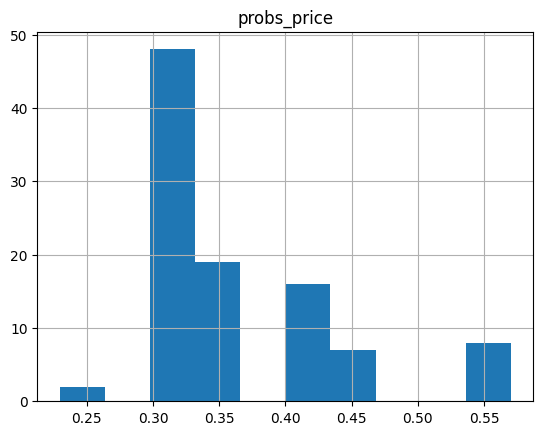

In [21]:
predictions.hist()

# Inspecting the Model

### Global Explain

A global explanation prints the logic learned for each class.  The `quantile` parameter is the percent of the model you would like to be explained.

In this tutorial we used a data transformation technique called FeatureBinarizationFromTrees that uses a tree-based model to binarize continuous valued features into boolean features.  For example, we may create two features during this process that correspond to "X >= 3", "X < 3", "X >= 1.5", "X < 1.5", each of which takes values 0 or 1.  In addition, our categorical features have been dummy encoded, and therefore also take the values 0 or 1.

In this scenario, the bounds learned in our Reasoning Network can effectively be ignored for many use cases (not to say they are not informative!). For this reason, we have set `show_bounds=False` in the explanations below because the features themselves include bounds on the features.

In [ ]:
print(best_model.explain(
    quantile=1.0,
    required_output_thresholds=torch.tensor(.5),
    explain_type='both',
    print_type='natural', 
    explanation_prefix="A house has a",
    target_names=['price'],
    ignore_uninformative=True,
    rounding_precision=3,
    show_bounds=False,
    inverse_transform_target=mmsy.inverse_transform
))

In [23]:
print(best_model.explain(
    quantile=1.0,
    required_output_thresholds=torch.tensor(.5),
    explain_type='both',
    print_type='natural', 
    explanation_prefix="A house has a",
    target_names=['price'],
    ignore_uninformative=True,
    rounding_precision=3,
    show_bounds=False,
    inverse_transform_target=mmsy.inverse_transform
))

A house has a predicted price of 2.8 because: 

In various scenarios, this prediction could prove to be correct.  The first scenario that could be met is as follows.  It was NOT true the average number of rooms is less than or equal to 5.5, and the average occupancy is less than or equal to 3.4.

The next scenario that could be met is as follows.  The age of the house is less than or equal to 28.5, and the median income is greater than 5.7


### Sample Explain

A sample explanation prints the logic that was used for a particular sample's predition. The `quantile` parameter is the percent of the model you would like to be explained.

In [24]:
idx = 0

In [25]:
print(best_model.explain_samples(
    val_dataset[idx]['features'].unsqueeze(0), 
    quantile=1.0,
    target_names=['price'], 
    explain_type='both',
    sample_explanation_prefix="The house has a",
    print_type='logical-natural',
    ignore_uninformative=False,
    rounding_precision=5,
    # inverse_transform_features=mms.inverse_transform,
    show_bounds=False,
    inverse_transform_target=mmsy.inverse_transform,
    simplify=True
))

0: The house has a a predicted price of 2.63149 because: 


All the following are true: 
	The age of the house was between 28.5 and 47
	The average occupancy was greater than 3.4


### Printing the weights

We can inspect the weights the model learned for each logic to see how important they are to the overall prediction.

In [26]:
best_model.print_samples(
    val_dataset[idx]['features'].unsqueeze(0),
    quantile=1.0,
    target_names=['price'], 
    explain_type='both',
    print_type='logical',
    ignore_uninformative=False,
    rounding_precision=5,
    # inverse_transform=mms.inverse_transform,
)

REASONING NETWORK MODEL FOR: price
Logic at depth 2: the age of the house is greater than 47.0 >= 1.0
output: tensor([0., 0.])

Logic at depth 1: ['NOT(the age of the house is greater than 47.0 >= 1.0)']
weights: tensor([-0.0309,  0.0453])
output: 0.04531592130661011
required_threshold: 0.11905547231435776

Logic at depth 2: NOT(the age of the house is less than or equal to 28.5 >= 0.13877)
output: tensor([1., 0.])

Logic at depth 1: ['NOT(the age of the house is less than or equal to 28.5 >= 0.13877)']
weights: tensor([0.4719, 0.1215])
output: 0.8784533739089966
required_threshold: 0.8953201770782471

Logic at depth 2: NOT(the average occupancy is less than or equal to 3.4 >= 0.06143)
output: tensor([0., 0.])

Logic at depth 1: ['NOT(the average occupancy is less than or equal to 3.4 >= 0.06143)']
weights: tensor([ 0.2560, -0.3503])
output: 0.743966281414032
required_threshold: 0.759693443775177

Logic at depth 0: ['OR(NOT(the age of the house is greater than 47.0 >= 1.0), NOT(the age

In [27]:
best_model.print(
    quantile=1.0,
    required_output_thresholds=torch.tensor(0.7),
    explain_type='both',
    print_type='logical', 
    target_names=['price'],
    ignore_uninformative=False,
    rounding_precision=5,
    # inverse_transform=mms.inverse_transform,
)

REASONING NETWORK MODEL FOR: price
Logic at depth 2: 
output: tensor([1., 0.])

Logic at depth 2: the age of the house is less than or equal to 28.5 >= 1.0, the median income is greater than 5.7 >= 1.0
output: tensor([1., 1.])

Logic at depth 1: ['AND(the age of the house is less than or equal to 28.5 >= 1.0, the median income is greater than 5.7 >= 1.0)']
weights: tensor([0.4719, 0.1215])
output: 1.0
required_threshold: 1.0

Logic at depth 2: NOT(the average number of rooms is less than or equal to 5.5 >= 0.0), the average occupancy is less than or equal to 3.4 >= 1.0
output: tensor([1., 0.])

Logic at depth 1: ['AND(NOT(the average number of rooms is less than or equal to 5.5 >= 0.0), the average occupancy is less than or equal to 3.4 >= 1.0)']
weights: tensor([ 0.2560, -0.3503])
output: 1.0
required_threshold: 1.0

Logic at depth 0: ['OR(AND(NOT(the average number of rooms is less than or equal to 5.5 >= 0.0), the average occupancy is less than or equal to 3.4 >= 1.0), AND(the age o